In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_ML_functions_and_feature_ranking as functions
import RF_target_predicting_and_learning_curves_functions as tp_lc_functions

from scipy.optimize import curve_fit

In [2]:
import os
# os.mkdir('TNG300-SAM_images/v10_TNG300-SAM_WeightedRadius_vs_HalfmassRad')

In [3]:
# Raw dataset from TNG300 Notebook v1,
# the version of dataset without non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2,
# and with stellar mass cut at log10Mstar>9.0
# and without fdisk<0.02 galaxies
df_not_normalized = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_diskgals_w_smallfdisk.csv') 

# Set all Spin<0.02 equal to 0.02
df_not_normalized.loc[:,'HalopropSpin_effective']=df_not_normalized.loc[:,'HalopropSpin'].apply(lambda x: 0.02 if x<0.02 else x)

df_not_normalized = df_not_normalized.drop(columns=['HalopropSpin'])

# Rename Spin_effective back to Spin because all the rest of the code has this name used
df_not_normalized = df_not_normalized.rename(columns={'HalopropSpin_effective': 'HalopropSpin'})

# Save the Raw Dataset with Spin Effective
# df_not_normalized.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_diskgals_w_smallfdisk_w_spineffective.csv', index=False)

df_not_normalized.shape

(207467, 59)

In [4]:
# Normalized (in better words, dimensionless) dataset from TNG300 Notebook v1: 
# all masses divided by halo mass (Mvir), halfmass radius divided by halo size (Rhalo);
# the version of dataset without non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2
# and with stellar mass cut at log10Mstar>9.0

# read the same file again
df_normalized_35 = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_diskgals_w_smallfdsik.csv')
# Set all Spin<0.02 equal to 0.02
df_normalized_35.loc[:,'HalopropSpin_effective']=df_normalized_35.loc[:,'HalopropSpin'].apply(lambda x: 0.02 if x<0.02 else x)
df_normalized_35 = df_normalized_35.drop(columns=['HalopropSpin'])
# Rename Spin_effective back to Spin because all the rest of the code has this name used
df_normalized_35 = df_normalized_35.rename(columns={'HalopropSpin_effective': 'HalopropSpin'})

# Save the Normalized Dataset with Spin Effective
# df_normalized_35.to_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_diskgals_w_smallfdsik_w_spineffective.csv', index=False)

df_normalized_35.shape

(207467, 38)

In [5]:
df_not_normalized.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropLogSfr',
 'Galprop

In [6]:
df_not_normalized.loc[:, 'Weighted_Rad'] = df_not_normalized.loc[:, 'GalpropRbulge']*(df_not_normalized.loc[:, 'GalpropMbulge']/df_not_normalized.loc[:,'GalpropMstar']) + \
                            1.68*df_not_normalized.loc[:, 'GalpropRdisk']*(df_not_normalized.loc[:, 'GalpropMdisk']/df_not_normalized.loc[:,'GalpropMstar'])

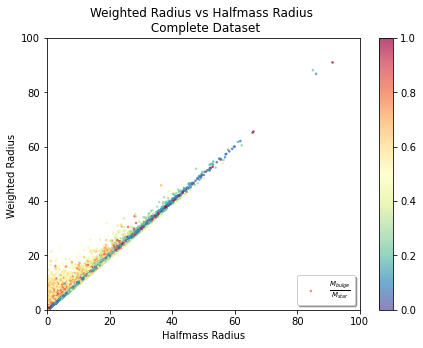

In [19]:
fig_complete, ax = plt.subplots(figsize=(7, 5))

fig = ax.scatter(df_not_normalized.loc[:, 'GalpropHalfRadius'], df_not_normalized.loc[:, 'Weighted_Rad'],
                       c = df_not_normalized.loc[:, 'GalpropMbulge']/df_not_normalized.loc[:,'GalpropMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=1.0)

ax.axis([0.0,100, 0.0,100])
# ax.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 1)
ax.set_title('Weighted Radius vs Halfmass Radius \n Complete Dataset')
ax.set_xlabel('Halfmass Radius')
ax.set_ylabel('Weighted Radius ')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig, ax=ax)
# plt.savefig('TNG300-SAM_images/v10_TNG300-SAM_WeightedRadius_vs_HalfmassRad/v10_WeightedRad_vs_HalfmassRad_CompleteDataset.jpeg', dpi=500)
plt.show()

In [18]:
# Combined morphologies 1 to 4 in order to fit one physical model to all of them; 
# 158,501 galaxies in the 1-4 morphologies, out of a total of ~207,000
df_14 = df_normalized_35.loc[df_normalized_35.BulgeMstar_ratio <= 0.40] #normalized
df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 

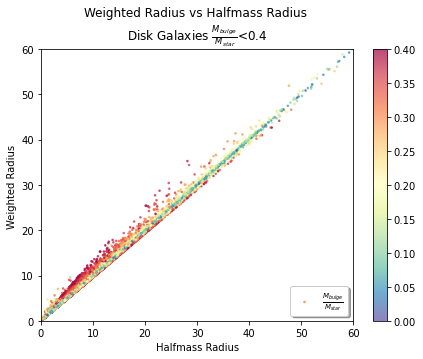

In [25]:
fig_complete, ax = plt.subplots(figsize=(7, 5))

fig = ax.scatter(df_14_raw.loc[:, 'GalpropHalfRadius'], df_14_raw.loc[:, 'Weighted_Rad'],
                       c = df_14_raw.loc[:, 'GalpropMbulge']/df_14_raw.loc[:,'GalpropMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)

ax.axis([0.0,60, 0.0,60])
# ax.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 1)
ax.set_title('Weighted Radius vs Halfmass Radius \n' +  r'Disk Galaxies $\frac{M_{bulge}}{M_{star}}$<0.4')
ax.set_xlabel('Halfmass Radius')
ax.set_ylabel('Weighted Radius ')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig, ax=ax)
# plt.savefig('TNG300-SAM_images/v10_TNG300-SAM_WeightedRadius_vs_HalfmassRad/v10_WeightedRad_vs_HalfmassRad_DiskGalaxies_df_14.jpeg', dpi=500)
plt.show()

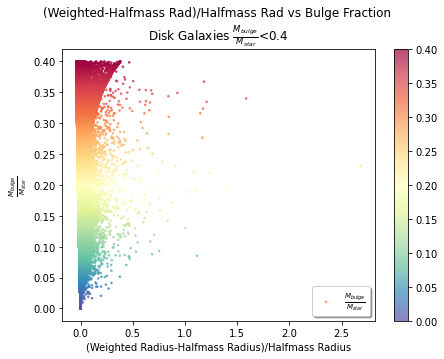

In [42]:
# (weighted radius - half mass radius)/half mass radius  vs Mb/Mstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig = ax.scatter((df_14_raw.loc[:, 'Weighted_Rad'] - df_14_raw.loc[:, 'GalpropHalfRadius'])/df_14_raw.loc[:, 'GalpropHalfRadius'],
                 (df_14_raw.loc[:, 'GalpropMbulge']/df_14_raw.loc[:,'GalpropMstar']),
                       c = df_14_raw.loc[:, 'GalpropMbulge']/df_14_raw.loc[:,'GalpropMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)

# ax.axis([-0.01,1.4, -0.01,0.41])
# ax.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 1)
ax.set_title('(Weighted-Halfmass Rad)/Halfmass Rad vs Bulge Fraction \n' +  r'Disk Galaxies $\frac{M_{bulge}}{M_{star}}$<0.4')
ax.set_xlabel('(Weighted Radius-Halfmass Radius)/Halfmass Radius')
ax.set_ylabel(r'$\frac{M_{bulge}}{M_{star}}$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig, ax=ax)
# plt.savefig('TNG300-SAM_images/v10_TNG300-SAM_WeightedRadius_vs_HalfmassRad/v10_WeightedRad_HalfmassRad_vs_BulgeFraction_DiskGalaxies_df_14.jpeg', dpi=500)
plt.show()

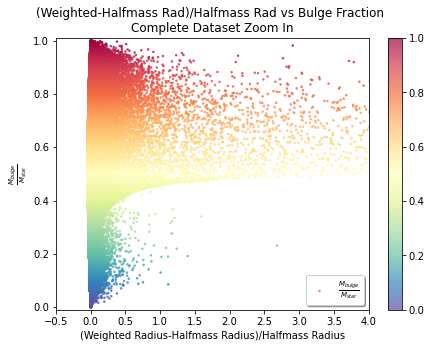

In [52]:
# (weighted radius - half mass radius)/half mass radius  vs Mb/Mstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig = ax.scatter((df_not_normalized.loc[:, 'Weighted_Rad'] - df_not_normalized.loc[:, 'GalpropHalfRadius'])/df_not_normalized.loc[:, 'GalpropHalfRadius'],
                 (df_not_normalized.loc[:, 'GalpropMbulge']/df_not_normalized.loc[:,'GalpropMstar']),
                       c = df_not_normalized.loc[:, 'GalpropMbulge']/df_not_normalized.loc[:,'GalpropMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=1.0)

ax.axis([-0.5,4, -0.01,1.01])
# ax.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 1)
ax.set_title('(Weighted-Halfmass Rad)/Halfmass Rad vs Bulge Fraction \n' +  r'Complete Dataset Zoom In')
ax.set_xlabel('(Weighted Radius-Halfmass Radius)/Halfmass Radius')
ax.set_ylabel(r'$\frac{M_{bulge}}{M_{star}}$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig, ax=ax)
# plt.savefig('TNG300-SAM_images/v10_TNG300-SAM_WeightedRadius_vs_HalfmassRad/v10_WeightedRad_HalfmassRad_vs_BulgeFraction_CompleteDataset_v3.jpeg', dpi=500)
plt.show()